<a href="https://colab.research.google.com/github/suyashss/nn_test/blob/master/neural_style_transfer_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [3]:
import tensorflow.keras as keras

## Load VGG model and extract convolutional layers

In [4]:
vgg = keras.applications.VGG19(include_top=True,weights='imagenet')

574717952/574710816 [==============================] - 9s 0us/step


In [5]:
select_layer_names = ['block{}_conv1'.format(x) for x in range(1,6)]
print(select_layer_names)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


# Get image and view

In [73]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [94]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [95]:
content_path = '1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

## Define utility functions for image processing and viewing

In [96]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = keras.preprocessing.image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [97]:
def preprocess_img(path_to_img):
  img = load_img(path_to_img)
  out = keras.applications.vgg19.preprocess_input(img)
  return out

In [98]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [99]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

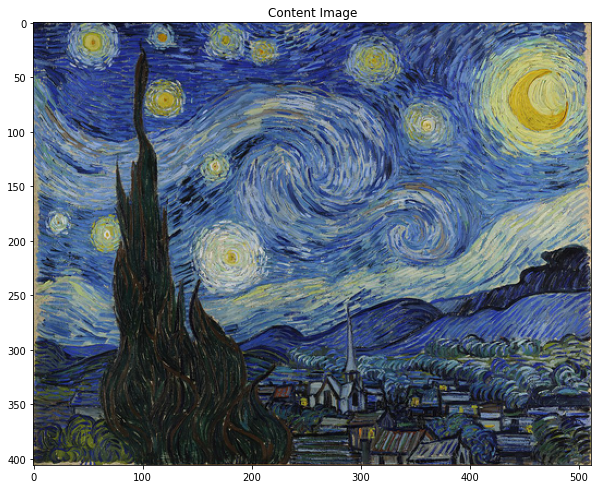

In [100]:
content = load_img(content_path).astype('uint8')
#style = load_img(style_path).astype('uint8')

#plt.subplot(1, 1, 1)
imshow(content, 'Content Image')

#plt.subplot(1, 2, 2)
#imshow(style, 'Style Image')
plt.show()


## Define model to get outputs of selected convolutional layers

In [101]:
intermediate_layer_model = keras.Model(inputs=vgg.input,
                                       outputs=[vgg.get_layer(layer_name).output for layer_name in select_layer_names])

In [102]:
content_vgg_in = preprocess_img(content_path)

In [103]:
intermediate_outputs = intermediate_layer_model(content_vgg_in)

In [104]:
for x in intermediate_outputs:
  print(x.shape)

(1, 406, 512, 64)
(1, 203, 256, 128)
(1, 101, 128, 256)
(1, 50, 64, 512)
(1, 25, 32, 512)


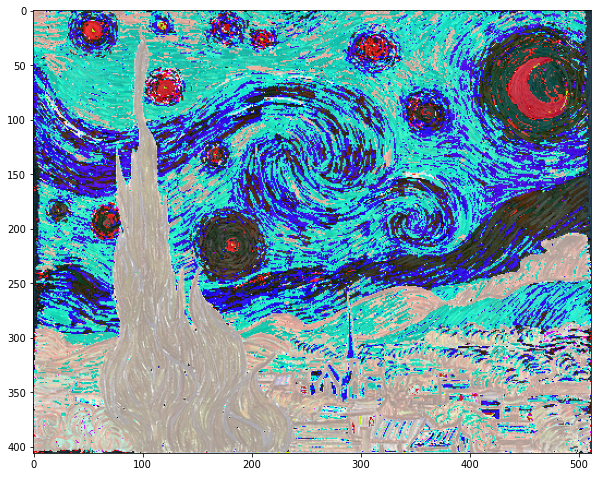

In [105]:
imshow(content_vgg_in)

In [106]:
temp = deprocess_img(content_vgg_in)
print(temp.shape)

(406, 512, 3)


In [107]:
content_vgg_in.shape

(1, 406, 512, 3)

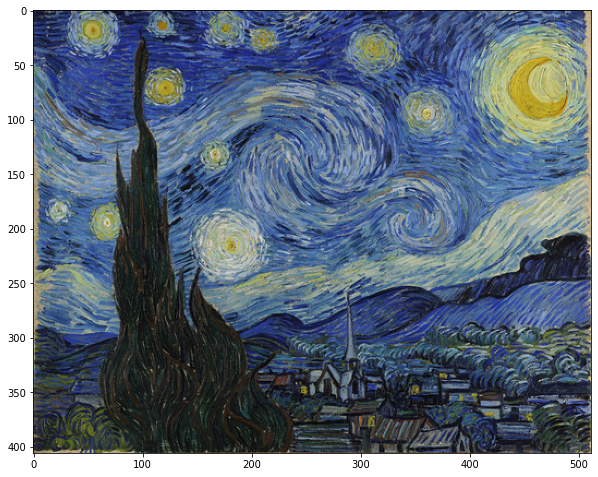

In [108]:
imshow([temp])

# Content reconstruction experiments

In [109]:
def content_loss(img1_feat,img2,model,layer_idx): # Features for a specific layer 
  return tf.reduce_mean(tf.square(img1_feat - model(img2)[layer_idx]))  

In [110]:
def content_grads(img1_feat,init_image,model,layer_idx):
  with tf.GradientTape() as tape: 
    #tape.watch(init_image)
    all_loss = content_loss(img1_feat,init_image,model,layer_idx)
  # Compute gradients wrt input image
  return tape.gradient(all_loss, init_image), all_loss

In [111]:
opt = tf.optimizers.Adam(learning_rate=15,)

In [124]:
def run_content_reconstruction_loop(content_vgg_in,opt,layer_idx):
  init_image = tf.Variable(tf.random.uniform(content_vgg_in.shape,minval=0,maxval=255,dtype='float32'))
  target_out = intermediate_layer_model(content_vgg_in)
  num_iterations = 100
  loss_seq = []
  image_seq = [init_image]
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means 
  for i in range(num_iterations):
    image_out = intermediate_layer_model(init_image)
    grads, curr_loss = content_grads(target_out[layer_idx],init_image,intermediate_layer_model,layer_idx)
    loss_seq.append(curr_loss)
    if i % 10 ==0:
      print("Iteration = {}, loss = {}".format(i,curr_loss))
      image_seq.append(init_image)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
  return image_seq,loss_seq   

## Test reconstruction at layer 0

Iteration = 0, loss = 6696.28955078125
Iteration = 10, loss = 635.2537841796875
Iteration = 20, loss = 142.7472686767578
Iteration = 30, loss = 48.864253997802734
Iteration = 40, loss = 21.19818687438965
Iteration = 50, loss = 8.17078685760498
Iteration = 60, loss = 2.731379747390747
Iteration = 70, loss = 0.9506908655166626
Iteration = 80, loss = 0.4045850336551666
Iteration = 90, loss = 0.20728661119937897


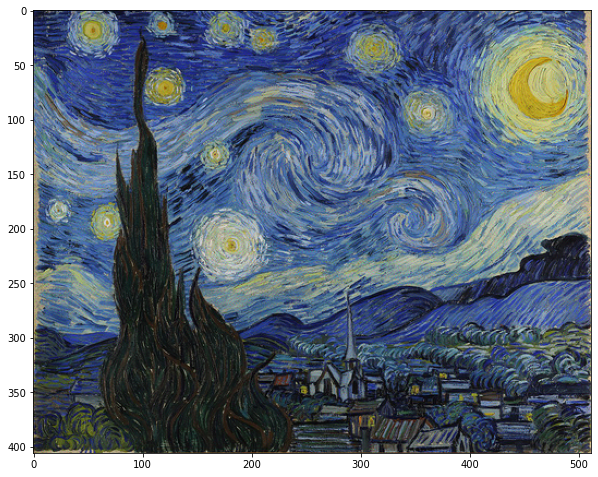

In [125]:
im_seq,loss_seq = run_content_reconstruction_loop(content_vgg_in,opt,0)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

## Test reconstruction at layer 4

Iteration = 0, loss = 15901.1171875
Iteration = 10, loss = 6109.8798828125
Iteration = 20, loss = 3633.450927734375
Iteration = 30, loss = 2575.321044921875
Iteration = 40, loss = 2010.8448486328125
Iteration = 50, loss = 1606.560791015625
Iteration = 60, loss = 1352.2288818359375
Iteration = 70, loss = 1116.8536376953125
Iteration = 80, loss = 954.8831787109375
Iteration = 90, loss = 753.3057861328125


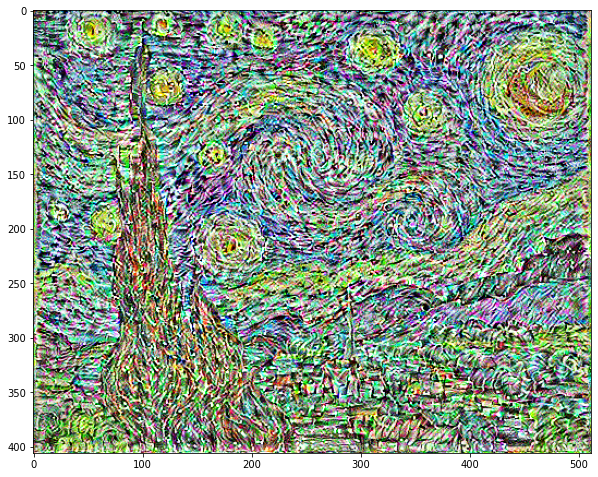

In [126]:
im_seq,loss_seq = run_content_reconstruction_loop(content_vgg_in,opt,4)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

# Style reconstruction experiments

In [115]:
def compute_gram(img_feat):
  img_shape = img_feat.shape
  img_vec = tf.reshape(img_feat,[-1,img_shape[-1]])
  n = tf.cast(img_vec.shape[0]*img_vec.shape[1],'float32')
  g = tf.matmul(a=img_vec,b=img_vec,transpose_a=True)/n
  return g

In [116]:
def style_loss(img1_gram,img2,model,layer_idx): # Features for a specific layer 
  img2_feat = model(img2)
  img2_gram = [compute_gram(x) for x in img2_feat[0:layer_idx]]
  return tf.reduce_mean(tf.convert_to_tensor([tf.reduce_mean(tf.square(x-y)) for x,y in zip(img1_gram,img2_gram)]))
#  return tf.reduce_mean(tf.square(tf.convert_to_tensor(img1_gram[:layer_idx]) - tf.convert_to_tensor(img2_gram[:layer_idx])))  

In [117]:
def style_grads(img1_gram,init_image,model,layer_idx):
  with tf.GradientTape() as tape: 
    all_loss = style_loss(img1_gram,init_image,model,layer_idx)
  # Compute gradients wrt input image
  return tape.gradient(all_loss, init_image), all_loss

In [130]:
def run_style_reconstruction_loop(content_vgg_in,opt,layer_idx):
  init_image = tf.Variable(tf.random.uniform(content_vgg_in.shape,minval=0,maxval=255,dtype='float32'))
  target_out = intermediate_layer_model(content_vgg_in)
  target_gram = [compute_gram(x) for x in target_out[0:layer_idx]]  
  num_iterations = 1000
  loss_seq = []
  image_seq = [init_image]
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  for i in range(num_iterations):
    image_out = intermediate_layer_model(init_image)
    grads, curr_loss = style_grads(target_gram,init_image,intermediate_layer_model,layer_idx)
    loss_seq.append(curr_loss)
    if i % 50 ==0:
      print("Iteration = {}, loss = {}".format(i,curr_loss))
      image_seq.append(init_image)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    if curr_loss < 0.01:
      break
  return image_seq,loss_seq   

## Test reconstruction at layer 0

Iteration = 0, loss = 4729.884765625
Iteration = 50, loss = 1.2169063091278076
Iteration = 100, loss = 0.021055612713098526


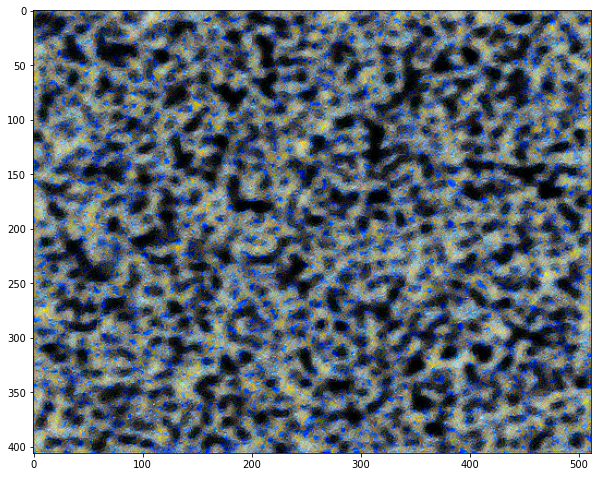

In [131]:
im_seq,loss_seq = run_style_reconstruction_loop(content_vgg_in,opt,1)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

## Test reconstruction at layers 0 through 4

Iteration = 0, loss = 1535334.25
Iteration = 50, loss = 2598.3583984375
Iteration = 100, loss = 749.4837646484375
Iteration = 150, loss = 459.17205810546875
Iteration = 200, loss = 338.2441101074219
Iteration = 250, loss = 271.6799011230469
Iteration = 300, loss = 229.7604522705078
Iteration = 350, loss = 200.82901000976562
Iteration = 400, loss = 179.40870666503906
Iteration = 450, loss = 162.75753784179688
Iteration = 500, loss = 149.31399536132812
Iteration = 550, loss = 138.1419677734375
Iteration = 600, loss = 128.61317443847656
Iteration = 650, loss = 120.38209533691406
Iteration = 700, loss = 113.14225769042969
Iteration = 750, loss = 106.71329498291016
Iteration = 800, loss = 100.95144653320312
Iteration = 850, loss = 95.74837493896484
Iteration = 900, loss = 91.01715850830078
Iteration = 950, loss = 86.68743896484375


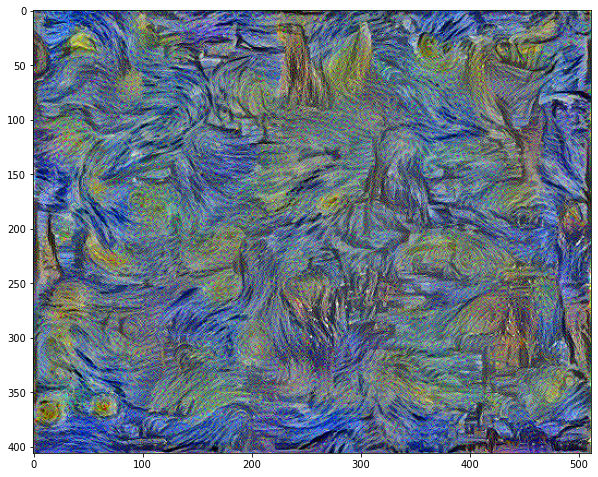

In [132]:
im_seq,loss_seq = run_style_reconstruction_loop(content_vgg_in,opt,5)
plt.imshow(deprocess_img(im_seq[-1].numpy()))